In [8]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia
import math

In [9]:
v_df = pd.read_csv('pio11_ephemeris.csv') #pioneer 11 ephemeris 
s_df = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt']) #empty dataframe for encountered stars

In [10]:
v_df['year'] = 0
v_df['month'] = 0
v_df['day'] = 0
v_df['hour'] = 0
v_df['min'] = 0
v_df['sec'] = 0
v_df['total_time'] = 0
v_df['time_lasts'] = 0

for i in range(len(v_df.index)):
    v_df['year'][i] = float(v_df['date'][i][:4])
    v_df['month'][i] = v_df['date'][i][5:8]
    v_df['day'][i] = float(v_df['date'][i][9:11])
    v_df['hour'][i] = float(v_df['date'][i][12:14])
    v_df['min'][i] = float(v_df['date'][i][15:17])
    v_df['sec'][i] = v_df['date'][i][18:]
    
    if v_df['month'][i] == "Jan":
        v_df['month'][i] = 0
        
    elif v_df['month'][i] == "Feb":
        v_df['month'][i] = 1
        
    elif v_df['month'][i] == "Mar":
        v_df['month'][i] = 2
        
    elif v_df['month'][i] == "Apr":
        v_df['month'][i] = 3
        
    elif v_df['month'][i] == "May":
        v_df['month'][i] = 4
        
    elif v_df['month'][i] == "Jun":
        v_df['month'][i] = 5
        
    elif v_df['month'][i] == "Jul":
        v_df['month'][i] = 6
        
    elif v_df['month'][i] == "Aug":
        v_df['month'][i] = 7
        
    elif v_df['month'][i] == "Sep":
        v_df['month'][i] = 8
        
    elif v_df['month'][i] == "Oct":
        v_df['month'][i] = 9
        
    elif v_df['month'][i] == "Nov":
        v_df['month'][i] = 10
        
    elif v_df['month'][i] == "Dec":
        v_df['month'][i] = 11
    
    #calc total time (since 0/0/0) in seconds
    v_df['total_time'][i] = v_df['year'][i] * 31536000 + v_df['month'][i] * 2628288 + v_df['day'][i] * 86400 + v_df['hour'][i] * 3600 + v_df['min'][i] * 60 + float(v_df['sec'][i])
    
for i in range(len(v_df.index)-1):    
    v_df['time_lasts'][i] = v_df['total_time'][i+1] - v_df['total_time'][i]
    
print(v_df)

<ipython-input-10-bdaabe8958ac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['year'][i] = float(v_df['date'][i][:4])
<ipython-input-10-bdaabe8958ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['month'][i] = v_df['date'][i][5:8]
/Users/mikeyd1050/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-inp

      Unnamed: 0                      date         ra       dec  year month  \
0              0  1973-Apr-07 00:00:00.000  290.69755 -34.80406  1973     3   
1              1  1973-Apr-07 03:39:19.268  290.83081 -34.80316  1973     3   
2              2  1973-Apr-07 08:38:22.160  290.96087 -34.80213  1973     3   
3              3  1973-Apr-07 15:46:34.986  291.08670 -34.80097  1973     3   
4              4  1973-Apr-08 02:41:48.882  291.20674 -34.79963  1973     3   
...          ...                       ...        ...       ...   ...   ...   
4645          14  1995-Aug-02 20:56:05.928  271.80979  -7.70790  1995     7   
4646          15  1995-Aug-11 05:56:14.348  271.69563  -7.74700  1995     7   
4647          16  1995-Aug-20 20:24:23.880  271.58990  -7.79723  1995     7   
4648          17  1995-Sep-01 13:57:14.840  271.50209  -7.86460  1995     8   
4649          18  1995-Sep-17 12:39:19.441  271.46289  -7.96220  1995     8   

      day  hour  min     sec   total_time  time_las

In [4]:
#Cone search using max radius on first position in ephemeris
for i in range(len(v_df.index)):
    query = """SELECT source_id, ra, dec, phot_g_mean_mag+5*log10(parallax/1000)+5 AS g_abs, (phot_bp_mean_mag - phot_rp_mean_mag) AS bp_rp, parallax, parallax_error, 1000/parallax AS dist, pmra, pmdec
    FROM external.gaiaedr3_gcns_main_1
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.4527778))
    AND parallax > 0
    """

    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    results['date'] = v_df['date'][i]
    results['eph_pt'] = i; #stores which row in ephemeris from

    s_df = pd.concat([s_df, results], ignore_index = True)

print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
#Advance stars in list with motion
s_df['adv_ra'] = s_df['ra'] + 3.26*s_df['dist']*s_df['pmra']/1000*(0.000277778)
s_df['adv_dec'] = s_df['dec'] + 3.26*s_df['dist']*s_df['pmdec']/1000*(0.000277778)

print(s_df)

                 source_id          ra        dec      g_abs     bp_rp  \
0      6742962972412390912  290.524164 -35.063462  12.027115  3.036664   
1      6742969603841922432  290.548861 -34.876415   9.106355  1.974494   
2      6743723662660904064  290.333373 -34.743887   3.998850  0.683418   
3      6742969638201661568  290.556253 -34.863656  10.052384  2.207315   
4      6742973860154134144  290.792366 -34.802958   8.132189  1.910584   
...                    ...         ...        ...        ...       ...   
23764  4170909850027869696  271.507045  -8.108265   3.272962  0.668999   
23765  4170911190057513600  271.521796  -8.057595   4.840388  0.859129   
23766  4170995195304743552  271.155926  -7.692238   8.553287  2.114002   
23767  4170938261222994176  271.738210  -7.907149  13.931793  4.406260   
23768  4170934378572508160  271.903088  -7.922169  14.507326  0.965359   

        parallax  parallax_error       dist                      date  \
0      53.149780        0.021581  18.8

In [6]:
#Check that advanced ra and dec are within actual cone

final_stars = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt'])

for i in range(len(s_df.index)):
    dist = math.sqrt((v_df['ra'][s_df['eph_pt'][i]] - s_df['adv_ra'][i])**2 + (v_df['dec'][s_df['eph_pt'][i]] - s_df['adv_dec'][i])**2) #calculate distance between advanced position and center of beam
    
    if dist < 0.064: #if distance < radius of beam add to final version
        final_stars = final_stars.append(s_df.loc[s_df['source_id'] == s_df['source_id'][i]]) #add star to final version     

In [11]:
final_stars = pd.read_csv('pio11_stars_final_dup.csv') #final stars from above were saved in this file

final_stars['time_total'] = 0
final_stars = final_stars[final_stars['dist'] <= 100] #eliminate stars not in 100 pc

final_stars['num'] = 0 

for i in range(len(final_stars.index)):
    final_stars['num'][i] = i  #index of stars
    final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts
    
final_stars = final_stars.drop(['Unnamed: 0'], axis = 1) #drop extra column
    
final_stars.to_csv('pio11_stars_final_dup.csv') #save again 
print(final_stars) #all stars with duplicates

final_stars_unique = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt', 'time_total'])

<ipython-input-11-fe856694da7d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['num'][i] = i  #index of stars
<ipython-input-11-fe856694da7d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts


                source_id          ra        dec     g_abs     bp_rp  \
0     6742973860154134144  290.792366 -34.802958  8.132189  1.910584   
1     6742973860154134144  290.792366 -34.802958  8.132189  1.910584   
2     6742973860154134144  290.792366 -34.802958  8.132189  1.910584   
3     6742973860154134144  290.792366 -34.802958  8.132189  1.910584   
4     6742973860154134144  290.792366 -34.802958  8.132189  1.910584   
...                   ...         ...        ...       ...       ...   
3811  4158784092199871744  273.515854  -8.056674  8.604779  2.056888   
3812  4158784092199871744  273.515854  -8.056674  8.604779  2.056888   
3813  4158784092199871744  273.515854  -8.056674  8.604779  2.056888   
3814  4158784092199871744  273.515854  -8.056674  8.604779  2.056888   
3815  4158784092199871744  273.515854  -8.056674  8.604779  2.056888   

       parallax  parallax_error       dist                      date  \
0     16.723795        0.016346  59.795041  1973-Apr-07 00:00:0

In [12]:
num_hit = np.array([])     #number of times a star appears in search, index matches
total_times = np.array([])     #array of total times for each star, index matches

for i in range(len(final_stars.index)):
    if (final_stars['source_id'][i] not in final_stars_unique[['source_id']].to_numpy()):   #if star not in unique database
        final_stars_unique = final_stars_unique.append(final_stars.loc[final_stars['num'] == i]) #add star to unique df
        
        num_hit = np.append(num_hit, 1)  #add 1 hit
        
        total_time = final_stars['time_total'][i]   #add value to total time
        
        for j in range(i+1, len(final_stars.index)):   #search from next star in final_stars to end
            
            if final_stars['source_id'][j] == final_stars['source_id'][i]:    #if same star appears again add time and increase number of hits by 1
                total_time += final_stars['time_total'][j]
                num_hit[-1] += 1
                
        total_times = np.append(total_times, total_time)    #add total time to total times array

final_stars_unique['time_total'] = total_times.tolist()    #add total times and num hit as columns
final_stars_unique['num_hit'] = num_hit.tolist()
print(final_stars_unique)  #dataframe of stars without duplicates and with total times & num hits

                source_id          ra        dec      g_abs     bp_rp  \
0     6742973860154134144  290.792366 -34.802958   8.132189  1.910584   
10    6742980903898504192  291.064190 -34.842926  11.862047  3.275856   
21    6742969603841922432  290.548861 -34.876415   9.106355  1.974494   
31    6743634945817195776  289.760264 -35.015080   9.261003  2.055240   
38    6743492348602227712  288.583289 -34.981254   8.314133  1.913872   
...                   ...         ...        ...        ...       ...   
3724  4170792752034740608  270.360712  -7.957924  10.372992  2.561558   
3766  4170899954423211776  271.464708  -8.217856  12.242971  0.041866   
3783  4158858549755074176  272.516510  -8.193172   8.453947  1.946835   
3795  4158780656214242304  273.296013  -8.051754  12.812831  0.333330   
3807  4158784092199871744  273.515854  -8.056674   8.604779  2.056888   

       parallax  parallax_error       dist                      date  \
0     16.723795        0.016346  59.795041  1973-Ap

In [13]:
final_stars_unique.to_csv('pio11_results_error.csv') #save again 

In [14]:
print(final_stars.drop_duplicates(subset=['source_id'])) #checking that unique search works, same number

                source_id          ra        dec      g_abs     bp_rp  \
0     6742973860154134144  290.792366 -34.802958   8.132189  1.910584   
10    6742980903898504192  291.064190 -34.842926  11.862047  3.275856   
21    6742969603841922432  290.548861 -34.876415   9.106355  1.974494   
31    6743634945817195776  289.760264 -35.015080   9.261003  2.055240   
38    6743492348602227712  288.583289 -34.981254   8.314133  1.913872   
...                   ...         ...        ...        ...       ...   
3724  4170792752034740608  270.360712  -7.957924  10.372992  2.561558   
3766  4170899954423211776  271.464708  -8.217856  12.242971  0.041866   
3783  4158858549755074176  272.516510  -8.193172   8.453947  1.946835   
3795  4158780656214242304  273.296013  -8.051754  12.812831  0.333330   
3807  4158784092199871744  273.515854  -8.056674   8.604779  2.056888   

       parallax  parallax_error       dist                      date  \
0     16.723795        0.016346  59.795041  1973-Ap

In [15]:
final_stars_unique = final_stars_unique[final_stars_unique['parallax_error'] <= 0.34]
print(final_stars_unique) #final stars accounting for parallax error

final_stars_unique.to_csv('pio11_results.csv') #save again 

                source_id          ra        dec      g_abs     bp_rp  \
0     6742973860154134144  290.792366 -34.802958   8.132189  1.910584   
10    6742980903898504192  291.064190 -34.842926  11.862047  3.275856   
21    6742969603841922432  290.548861 -34.876415   9.106355  1.974494   
31    6743634945817195776  289.760264 -35.015080   9.261003  2.055240   
38    6743492348602227712  288.583289 -34.981254   8.314133  1.913872   
...                   ...         ...        ...        ...       ...   
3724  4170792752034740608  270.360712  -7.957924  10.372992  2.561558   
3766  4170899954423211776  271.464708  -8.217856  12.242971  0.041866   
3783  4158858549755074176  272.516510  -8.193172   8.453947  1.946835   
3795  4158780656214242304  273.296013  -8.051754  12.812831  0.333330   
3807  4158784092199871744  273.515854  -8.056674   8.604779  2.056888   

       parallax  parallax_error       dist                      date  \
0     16.723795        0.016346  59.795041  1973-Ap

In [16]:
s_df_og = pd.read_csv('pio11_stars.csv') #original star search
s_df_og = s_df_og[s_df_og['parallax_error'] <= 0.34]

print(s_df_og)

     Unnamed: 0  Unnamed: 0.1            source_id          ra        dec  \
0             0             0  6742973860154134144  290.792366 -34.802958   
1             1             1  6742980903898504192  291.064190 -34.842926   
2             2             2  6742969603841922432  290.548861 -34.876415   
3             3             3  6743634945817195776  289.760264 -35.015080   
4             4             4  6743492348602227712  288.583289 -34.981254   
..          ...           ...                  ...         ...        ...   
406         433           480  4170792752034740608  270.360712  -7.957924   
407         434           483  4170899954423211776  271.464708  -8.217856   
408         435           484  4158858549755074176  272.516510  -8.193172   
409         436           485  4158780656214242304  273.296013  -8.051754   
410         437           486  4158784092199871744  273.515854  -8.056674   

         g_abs     bp_rp   parallax  parallax_error       dist  \
0     8.1

In [17]:
s_df_missing = np.array([]) #stars missing from new search
s_df_added = np.array([])  #stars added by new search

og_source = s_df_og['source_id'].to_numpy()    #source ids of og search without error
new_source = final_stars_unique['source_id'].to_numpy()    #source ids of new search without error

print('Missing stars\n')

for i in range(len(og_source)):    #add stars in og but not new search to missing stars array
    if (og_source[i] not in new_source):
        s_df_missing = np.append(s_df_missing, og_source[i])
        
print(s_df_missing)        
print('\nTotal missing: ' + str(s_df_missing.size) + '\n')   #total number missing

print('Added stars\n')

for i in range(len(new_source)):     #add stars in new but not og to added stars array
    if (new_source[i] not in og_source):
        s_df_added = np.append(s_df_added, new_source[i])
        
print(s_df_added)        
print('\nTotal added: ' + str(s_df_added.size) + '\n')    #total number added

Missing stars

[4.05036060e+18 4.05184153e+18 6.77006002e+18 6.76968458e+18
 6.85278350e+18 6.85313036e+18 6.85903563e+18 6.85792739e+18
 6.83503607e+18 2.61230703e+18 2.44711617e+18 2.60738016e+18
 9.14678956e+16 9.18851259e+16 1.02819288e+17 1.29493990e+17
 1.24062299e+17 1.21303625e+17 2.17330710e+17 2.17342873e+17
 1.85127595e+17 1.85305127e+17 3.45576072e+18 3.45306475e+18
 3.45283801e+18 9.42229208e+17 7.08509973e+17 6.40343619e+17
 6.23278786e+17 6.23262667e+17 3.88853238e+18 3.86738266e+18
 3.86646271e+18 3.81744775e+18 3.70693051e+18 3.66405687e+18
 3.65256207e+18 3.65256207e+18 3.65030528e+18 4.35255982e+18
 4.35436642e+18 4.36024795e+18 4.17073547e+18]

Total missing: 43

Added stars

[6.76775654e+18 2.63155578e+18 2.63180550e+18 9.42190068e+16
 1.28033254e+17 7.08402530e+17 3.66366854e+18 3.66358254e+18
 3.66399486e+18 3.65174767e+18 3.65159755e+18 4.40112738e+18
 4.40230740e+18 4.40573286e+18 4.35729383e+18 4.17179867e+18
 4.17105162e+18 4.17102883e+18]

Total added: 18



In [18]:
pio11_stars = pd.read_csv('pio11_results.csv') #get csv
print(pio11_stars)

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  6742973860154134144  290.792366 -34.802958   8.132189   
1            10  6742980903898504192  291.064190 -34.842926  11.862047   
2            21  6742969603841922432  290.548861 -34.876415   9.106355   
3            31  6743634945817195776  289.760264 -35.015080   9.261003   
4            38  6743492348602227712  288.583289 -34.981254   8.314133   
..          ...                  ...         ...        ...        ...   
381        3724  4170792752034740608  270.360712  -7.957924  10.372992   
382        3766  4170899954423211776  271.464708  -8.217856  12.242971   
383        3783  4158858549755074176  272.516510  -8.193172   8.453947   
384        3795  4158780656214242304  273.296013  -8.051754  12.812831   
385        3807  4158784092199871744  273.515854  -8.056674   8.604779   

        bp_rp   parallax  parallax_error       dist                      date  \
0    1.910584  16.723795      

<ipython-input-19-caf6b8a30dd0>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


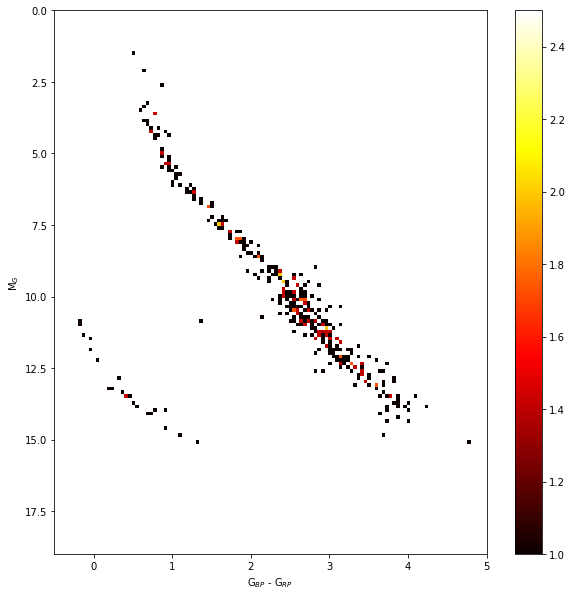

In [19]:
#build hr diagram
histogram, xedges, yedges = np.histogram2d(
   pio11_stars['bp_rp'], pio11_stars['g_abs'], bins=110)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.xlim(-0.5, 5)
plt.ylim(0, 19)

plt.colorbar()
plt.clim(1,2.5)

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('pio11_stars_hr.png')

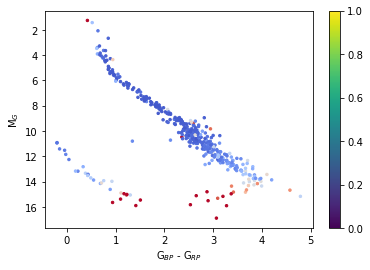

In [20]:
#color magnitude with stars removed from parallax error
cmap = plt.cm.get_cmap("coolwarm")
pio11_stars = pd.read_csv('pio11_results_error.csv')   #color magnitude including error stars

plt.scatter(pio11_stars['bp_rp'], pio11_stars['g_abs'], color = cmap(pio11_stars['parallax_error']*2), s = 6)

plt.colorbar()
plt.gca().invert_yaxis()

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')

plt.savefig("pio11_stars_error.png")

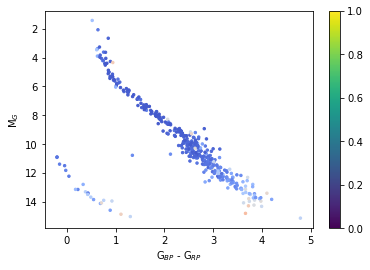

In [21]:
pio11_stars = pio11_stars[pio11_stars['parallax_error'] <= 0.34]     #With error filter of .34

cmap = plt.cm.get_cmap("coolwarm")

plt.scatter(pio11_stars['bp_rp'], pio11_stars['g_abs'], color = cmap(pio11_stars['parallax_error']*2), s = 6)

plt.colorbar()
plt.gca().invert_yaxis()

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')

plt.savefig("pio11_stars_error_removed.png")

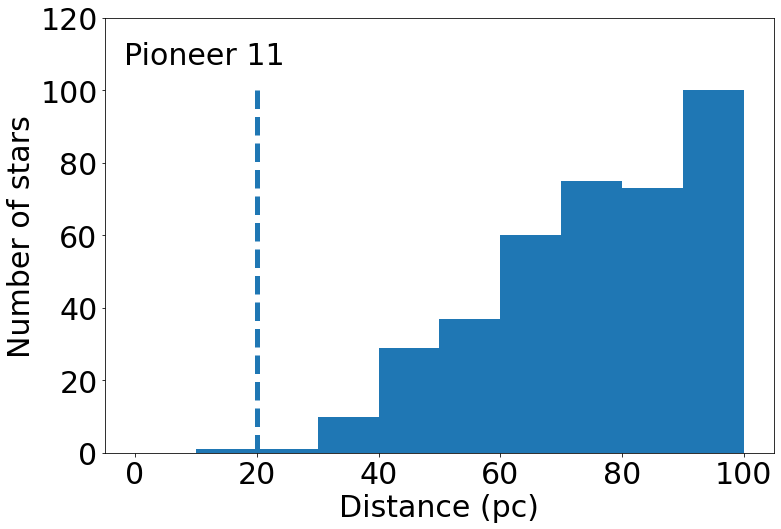

In [22]:
#distance histogram
pio11_stars = pd.read_csv('pio11_results.csv') #get csv

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 8))

plt.hist(abs(1000/pio11_stars['parallax']), bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #plot parallax (mas) converted to distance (pc) in histogram
plt.plot([20, 20], [0, 100], '--', linewidth=5, c='#1f77b4')

plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")
plt.figtext(0.24, 0.8, "Pioneer 11", wrap=True, horizontalalignment='center')

plt.ylim(0, 120)

plt.savefig("pio11_stars_dist.png")
plt.show()

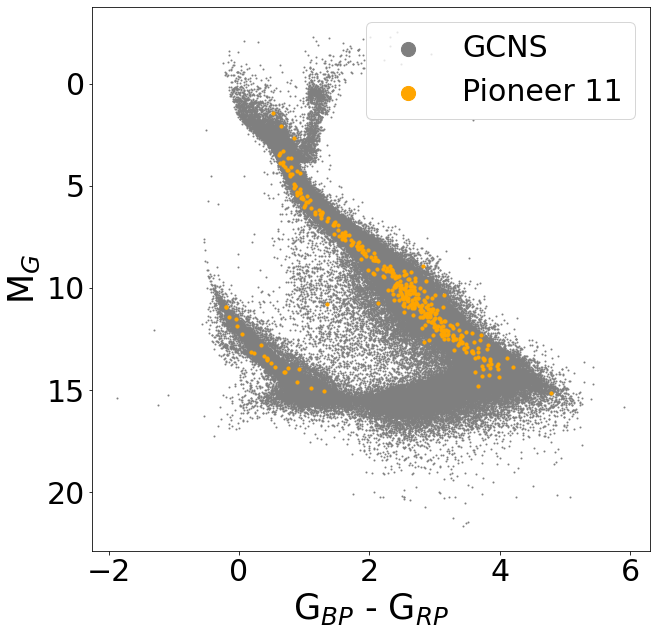

In [23]:
#HR with gcns in background

gcns = pd.read_csv('gcns_total.csv') #all stars in the GCNS database

plt.figure(figsize=(10, 10))

plt.scatter(gcns['bp_rp'], gcns['g_abs'], c = 'tab:gray', s = 1, label = "GCNS")
plt.scatter(pio11_stars['bp_rp'], pio11_stars['g_abs'], c = 'orange', s = 10, label = "Pioneer 11")

plt.gca().invert_yaxis()
plt.xlabel('G$_{BP}$ - G$_{RP}$', fontsize=35)
plt.ylabel('M$_G$', fontsize=35)

lgnd = plt.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]

plt.savefig("pio11_superset_hr.png")
plt.show()

In [24]:
star_results = pd.read_csv('pio11_results.csv')
star_results_error = pd.read_csv('pio11_results_error.csv')

star_results['time_total'] = star_results['time_total']/86400 #convert total time from seconds to hours
star_results_error['time_total'] =  star_results_error['time_total']/86400

print(star_results)
print(star_results_error)

star_results.to_csv('pio11_results.csv')
star_results_error.to_csv('pio11_results_error.csv')

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  6742973860154134144  290.792366 -34.802958   8.132189   
1            10  6742980903898504192  291.064190 -34.842926  11.862047   
2            21  6742969603841922432  290.548861 -34.876415   9.106355   
3            31  6743634945817195776  289.760264 -35.015080   9.261003   
4            38  6743492348602227712  288.583289 -34.981254   8.314133   
..          ...                  ...         ...        ...        ...   
381        3724  4170792752034740608  270.360712  -7.957924  10.372992   
382        3766  4170899954423211776  271.464708  -8.217856  12.242971   
383        3783  4158858549755074176  272.516510  -8.193172   8.453947   
384        3795  4158780656214242304  273.296013  -8.051754  12.812831   
385        3807  4158784092199871744  273.515854  -8.056674   8.604779   

        bp_rp   parallax  parallax_error       dist                      date  \
0    1.910584  16.723795      